# Laboratorio 1

- Daniel Alfredo Rayo Roldan
- Gerardo Pineda Riveiro

## Repo:
https://github.com/DanielRasho/DS-Lab2.git

In [1]:
# pip install openpyxl instalar esto
import rdata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input


from keras.models import Sequential,save_model,load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.metrics import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import keras
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

2025-07-26 14:16:47.138613: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-26 14:16:47.630014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/smaug/Documents/DataScience/lab2/.venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/smaug/Documents/DataScience/lab2/.venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is e

## Cargado de datos

### Consumo de Gas Licuado

Para el consumo de gas licuado por (dado en barriles de 42 galones) se contaron con registros mensuales desde 2020 hasta 2024, sumando un total de 300 registros.

| Inicio | Fin |Registros totales |
|--------|-----|------------------|
| 2020   | 2024| 300 |

In [2]:
hoja_df = pd.read_excel("./data/CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

# Select just necesary columns
gas_df = hoja_df[["Fecha", "Gas licuado de petróleo", "Año", "Mes"]]
gas_df = gas_df.set_index('Fecha').sort_index()
gas_df.head()

,Gas licuado de petróleo,Año,Mes
Fecha,,,
2000-01-01,194410.476190,2000,1
2000-02-01,174710.552381,2000,2
2000-03-01,189234.066667,2000,3
2000-04-01,174330.607143,2000,4
2000-05-01,191745.147619,2000,5


La serie temporal se puede ver en la figura siguiente, se puede apreciar una tendencia creciente desde 2020, teniendo una bajada abrupta (como es de esperar) durante el inicio de pandemia, la intención de este reporte buscara crear un modelo LSTM que prediga los ultimos 3 años registrado en la serie.

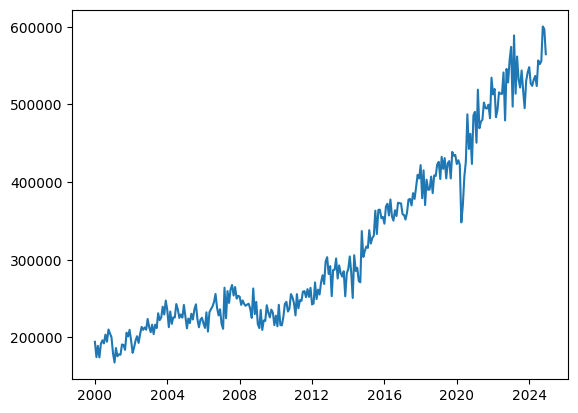

In [3]:
plt.plot(gas_df['Gas licuado de petróleo'])

Para eliminar los sesgos que pueda incurrir la media movil en las predicciones del modelo, se aplicara una diferenciacion; la nueva seria se visualiza en la siguiente figura, se puede observar como todos los datos giran alrededor del 0.

In [4]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = gas_df["Gas licuado de petróleo"].diff()
ts_air_pas_diff.fillna(0, inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -9.516841e+00
p-value                      3.140557e-16
# de retardos usados         5.000000e+00
# de observaciones usadas    2.940000e+02
Critical Value (1%)         -3.452790e+00
Critical Value (5%)         -2.871422e+00
Critical Value (10%)        -2.572035e+00
dtype: float64


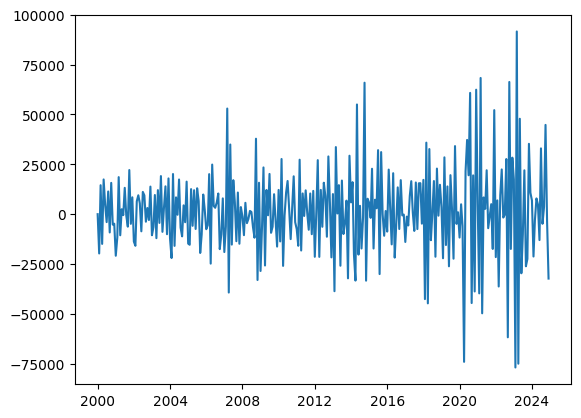

In [5]:
plt.plot(ts_air_pas_diff)

## Conjuntos de entrenamiento y prueba

Para el entrenamiento de la red neuronal LSTM los datos serán divididos en los siguientes grupos:

- 60% entrenamiento (178 registros)
- 20% validación (61 registros)
- 20% test (61 registros)

Antes de ser llevados al modelo serán estandarizados, el código para realizar esa preparación encuentra a continuación.

In [6]:
# Estandarización de los datos
df = ts_air_pas_diff.to_frame();
scaler = StandardScaler()
ts_air_pas_scaled = scaler.fit_transform(df[["Gas licuado de petróleo"]])

In [7]:
# División en los diferentes grupos
entrenamiento = round(0.6*len(ts_air_pas_scaled))
val_prueba = round(0.2*len(ts_air_pas_scaled))
test = ts_air_pas_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_air_pas_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_air_pas_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))

A diferencia de otros algoritmos, las redes LSTM utilizan los datos de respuesta tan solo son otro valor de la serie unos cuantos registros más adelante. En este caso, debido a la baja cantidad de datos se utilizará 1 retraso, es decir :

$$y = x_{n+1}$$

In [8]:
def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)

In [9]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

60

## Modelo 1

La arquitectura del primer model consta de una capa de inputs, seguido de la capa LSTM que recibe todos los inputs en un solo lote, para terminar con una red neuronal densa que evalue el output. Para este primer modelo se usara Adam como algoritmo de optmización y MSE como métrica de optomizazión.

In [10]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()


E0000 00:00:1753561010.305268  367439 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1753561010.321565  367439 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
#modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")
modelo1.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.1), metrics = [RootMeanSquaredError()])

In [15]:
epocas = 75
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=0
)

A continuación se ven las lineas de aprendizaje del modelo durante su entrenamiento se puede ver como el error de validación disminuye con el paso de las epocas, comparado al error con los datos de entrenamiento indicando que el modelo esta aprendiendo los patrones de las serie.

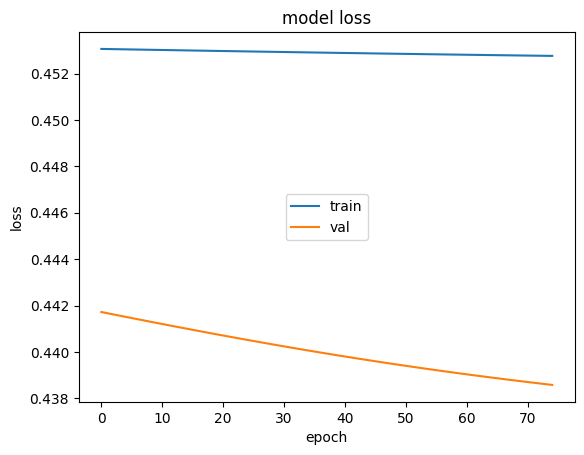

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

El siguiente grafico muestras las lineas de aprendizaje usando diferentes métricas, en todos los casos los errores para validación y entrenamiento se mantienen cerca, indicando que aunque el modelo aprende, no tiene sobreajuste.

<Axes: >

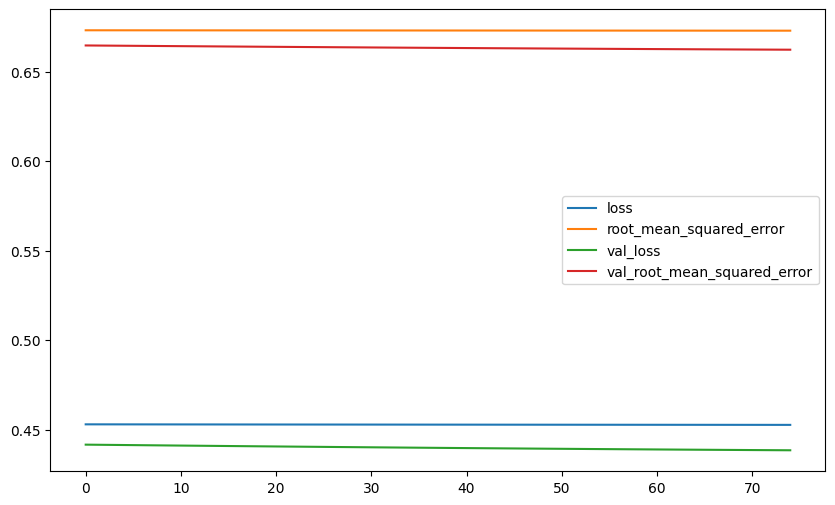

In [17]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

A continuación se realizaran las predicciones con el conjunto de prueba, dado que el modelo fue entrenado usando los datos estandarizados y diferenciados será necesario invertir estas transformaciones en los datos predichos por el modelo antes de calcular cualquier métrica.

In [19]:
def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = []
    reales = []
    
    for i, X in enumerate(data):
        index = n + dif_cant * i
        next_index = index + dif_cant

        if next_index >= len(Series):
            break  # Stop if we can't get a valid real value
        
        X = np.reshape(X, (1, 1, 1))
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        
        # Invert scaling
        yhat = scaler.inverse_transform(yhat)
        
        if dif:
            # Invert differencing
            yhat = yhat + Series[index]
            reales.append(Series[next_index])
        else:
            reales.append(Series[index])
        
        prediccion.append(yhat[0][0])
    
    return prediccion, reales
prediccion_val, val_real = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = gas_df["Gas licuado de petróleo"].values , n=entrenamiento)
prediccion_test, test_real = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = gas_df["Gas licuado de petróleo"].values , n=entrenamiento+val_prueba)


Estas son las métricas de error reales para el modelo, en promedio se el modelo se desfasa aproximadamente 39.5 mil barriles con respecto al valor verdadero, lo cuál es un error aceptable considerando que las predicciones se dan en el orden de los cien miles.

In [20]:
# Flatten predictions and true values
y_test_flat = test_real
y_pred_flat = prediccion_test

# Calculate metrics
mae = round(mean_absolute_error(y_test_flat, y_pred_flat), 5)
mse = round(mean_squared_error(y_test_flat, y_pred_flat), 5)
rmse = round(np.sqrt(mse), 5)
r2 = round(r2_score(y_test_flat, y_pred_flat), 5)

# Store in DataFrame
metrics_df = pd.DataFrame({
    "MAE": [mae],
    "MSE": [mse],
    "RMSE": [rmse],
})

metrics_df.transpose()

,0
MAE,3.022241e+04
MSE,1.559035e+09
RMSE,3.948461e+04


In [21]:
df_val = pd.DataFrame(prediccion_val,
                      index=df[["Gas licuado de petróleo"]].iloc[entrenamiento:entrenamiento + len(prediccion_val)].index)

start = entrenamiento + len(prediccion_val)
end = start + len(prediccion_test)
df_test = pd.DataFrame(prediccion_test,
                       index=df[["Gas licuado de petróleo"]].iloc[start:end].index)


La gráfica también refuerza la idea, mostrando que el modelo logra ajustarse a los picos y valles de la serie, incluso durante el comportamiento atípico de pandemia.

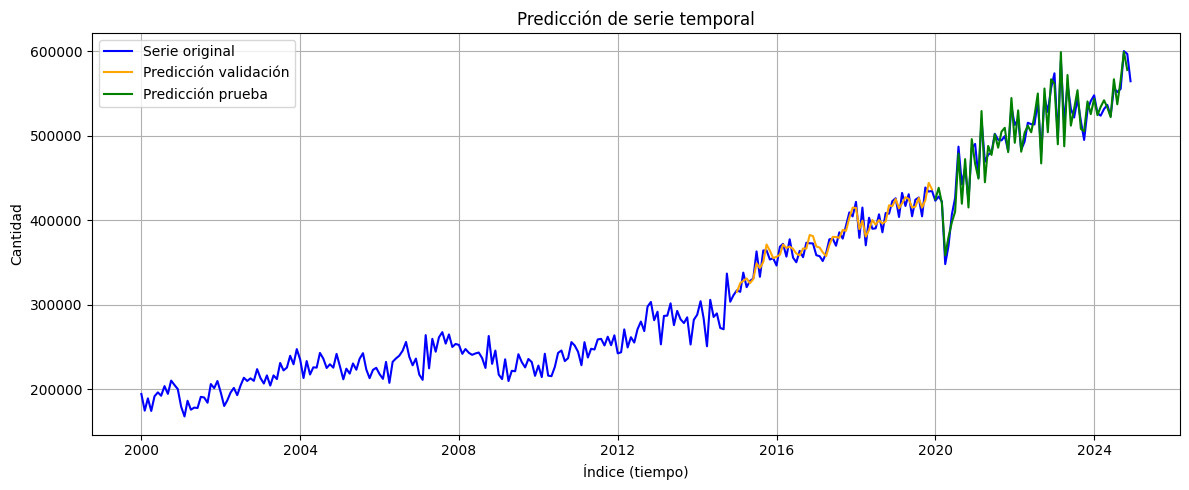

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))  

plt.plot(gas_df[["Gas licuado de petróleo"]], label="Serie original", color="blue")

plt.plot(df_val, label="Predicción validación", color="orange")

plt.plot(df_test, label="Predicción prueba", color="green")

plt.title("Predicción de serie temporal")
plt.xlabel("Índice (tiempo)")
plt.ylabel("Cantidad")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Modelo 2

Para el siguiente modelo se utilizo un buscador de hiperparámetros que probara con diferentes convinaciones para encontrar aquella que diera mejor rendimiento, se variaron los parámetros de : 

- Unidades
- Optimizador
- Taza de aprendizaje

El MSE siguio siendo la métrica a optimizar.

In [23]:
from keras_tuner import HyperParameters, RandomSearch
from tensorflow.keras.optimizers import Adam, SGD

def build_model(hp):
    model = Sequential()
    
    lote = 1
    paso = 1
    caracteristicas = 1  # Adjust if your input shape changes

    # Tune number of LSTM units
    unidades = hp.Int("units", min_value=4, max_value=64, step=4)
    
    # Tune optimizer choice
    optimizer_name = hp.Choice("optimizer", ["adam", "sgd"])
    
    # Tune learning rate
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    model.add(Input(batch_shape=(lote, paso, caracteristicas)))
    model.add(LSTM(units=unidades, stateful=True))
    model.add(Dense(1))

    # Create optimizer with tuned learning rate
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )
    
    return model

In [24]:
tuner = RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=1,
    directory="lstm_tuning",
    project_name="gas_forecasting"
)

tuner.search(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=1,  # Must match `lote`
    shuffle=False,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Reloading Tuner from lstm_tuning/gas_forecasting/tuner0.json


In [25]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)[0]

# Build the model again using the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train it again and save the history
epocas = 95
history = best_model.fit(
    x=x_train,
    y=y_train,
    batch_size=lote,  # Must match stateful batch shape
    epochs=epocas,
    shuffle=False,
    validation_data=(x_val, y_val),
    verbose=0
)

Las curvas de aprendizaje del modelo, disminuyen sumamente el error con respecto al modelo 1. En las últimas epocas parece que el modelo desaprendio algunos de los patrones, lo cual podría ser positivo para evitar sobreajuste.

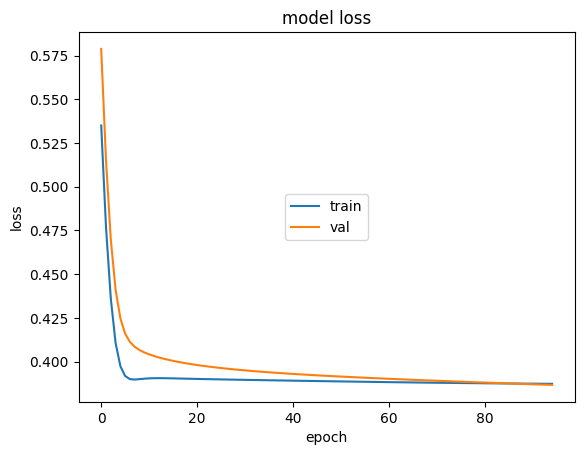

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [27]:
prediccion_val, val_real = prediccion_fun(x_val,best_model, 1,scaler,dif=True,dif_cant=1, Series = gas_df["Gas licuado de petróleo"].values , n=entrenamiento)
prediccion_test, test_real = prediccion_fun(x_test,best_model, 1,scaler,dif=True,dif_cant=1, Series = gas_df["Gas licuado de petróleo"].values , n=entrenamiento+val_prueba)

In [28]:
df_val = pd.DataFrame(prediccion_val,
                      index=df[["Gas licuado de petróleo"]].iloc[entrenamiento:entrenamiento + len(prediccion_val)].index)

start = entrenamiento + len(prediccion_val)
end = start + len(prediccion_test)
df_test = pd.DataFrame(prediccion_test,
                       index=df[["Gas licuado de petróleo"]].iloc[start:end].index)


Sin embargo, las métricas de error para este modelo parecen ser ligeramente peores, indicando que la configuración previa ya se encontraba en sus rangos optimos. Se puede concluir que el ajuste de parámetros no da una mejora significativa en la calidad de predicciones.

In [29]:
# Flatten predictions and true values
y_test_flat = test_real
y_pred_flat = prediccion_test

# Calculate metrics
mae = round(mean_absolute_error(y_test_flat, y_pred_flat), 5)
mse = round(mean_squared_error(y_test_flat, y_pred_flat), 5)
rmse = round(np.sqrt(mse), 5)
r2 = round(r2_score(y_test_flat, y_pred_flat), 5)

# Store in DataFrame
metrics_df = pd.DataFrame({
    "MAE": [mae],
    "MSE": [mse],
    "RMSE": [rmse],
    "R²": [r2]
})

metrics_df.transpose()

,0
MAE,3.205463e+04
MSE,1.828300e+09
RMSE,4.275862e+04
R²,2.962300e-01


La gráfica de predicciones tambien parece mostrar un mayor desfase entre la serie original y la predicha por el modelo.

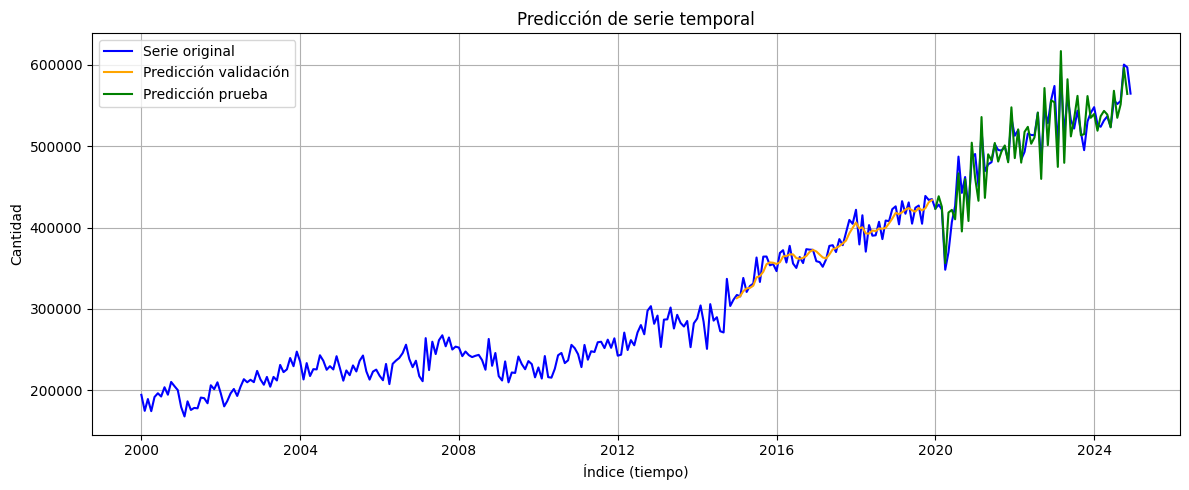

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))  

plt.plot(gas_df[["Gas licuado de petróleo"]], label="Serie original", color="blue")

plt.plot(df_val, label="Predicción validación", color="orange")

plt.plot(df_test, label="Predicción prueba", color="green")

plt.title("Predicción de serie temporal")
plt.xlabel("Índice (tiempo)")
plt.ylabel("Cantidad")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# Consumo de Gasolina Super

In [ ]:
hoja_df = pd.read_excel("./data/CONSUMO-HIDROCARBUROS-2024-12.xlsx", header=6)

hoja_df = hoja_df.iloc[:-3]

hoja_df["Fecha"] = pd.to_datetime(hoja_df["Fecha"])
hoja_df["Año"] = hoja_df["Fecha"].dt.year
hoja_df["Mes"] = hoja_df["Fecha"].dt.month

test_2023_2024 = hoja_df[hoja_df["Año"].isin([2023, 2024])][["Fecha", "Gasolina superior"]]

In [ ]:
train_data = hoja_df[hoja_df["Año"] < 2023][["Fecha", "Gasolina superior"]] # [hoja_df["Año"] < 2025]
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data["Año"] = train_data["Fecha"].dt.year
train_data["Mes"] = train_data["Fecha"].dt.month
train_data = train_data[~train_data["Año"].isin([2023, 2024, 2025])]
train_data


,Fecha,Gasolina superior,Año,Mes
0,2000-01-01,308156.82,2000,1
1,2000-02-01,307766.31,2000,2
2,2000-03-01,331910.29,2000,3
3,2000-04-01,315648.08,2000,4
4,2000-05-01,319667.97,2000,5
...,...,...,...,...
271,2022-08-01,581844.42,2022,8
272,2022-09-01,570632.20,2022,9
273,2022-10-01,573943.48,2022,10
274,2022-11-01,572163.23,2022,11


In [ ]:
train_data = hoja_df[hoja_df["Año"] < 2023][["Fecha", "Gasolina superior"]] # [hoja_df["Año"] < 2025]
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data["Año"] = train_data["Fecha"].dt.year
train_data["Mes"] = train_data["Fecha"].dt.month
train_data = train_data[~train_data["Año"].isin([2023, 2024, 2025])]
train_data

,Fecha,Gasolina superior,Año,Mes
0,2000-01-01,308156.82,2000,1
1,2000-02-01,307766.31,2000,2
2,2000-03-01,331910.29,2000,3
3,2000-04-01,315648.08,2000,4
4,2000-05-01,319667.97,2000,5
...,...,...,...,...
271,2022-08-01,581844.42,2022,8
272,2022-09-01,570632.20,2022,9
273,2022-10-01,573943.48,2022,10
274,2022-11-01,572163.23,2022,11


In [ ]:
hoja_df_2025 = pd.read_excel("./data/VENTAS-HIDROCARBUROS-2025-05.xlsx", header=6)
hoja_df_2025 = hoja_df_2025.iloc[:-3]

hoja_df_2025["Fecha"] = pd.to_datetime(hoja_df_2025["Fecha"])
hoja_df_2025["Año"] = hoja_df_2025["Fecha"].dt.year
hoja_df_2025["Mes"] = hoja_df_2025["Fecha"].dt.month

test_2025 = hoja_df_2025[["Fecha", "Gasolina superior"]]
test_data = pd.concat([test_2023_2024, test_2025], ignore_index=True)
test_data.set_index("Fecha", inplace=True)

In [ ]:
train_data = train_data.copy()
train_data["Fecha"] = pd.to_datetime(train_data["Fecha"])
train_data.set_index("Fecha", inplace=True)

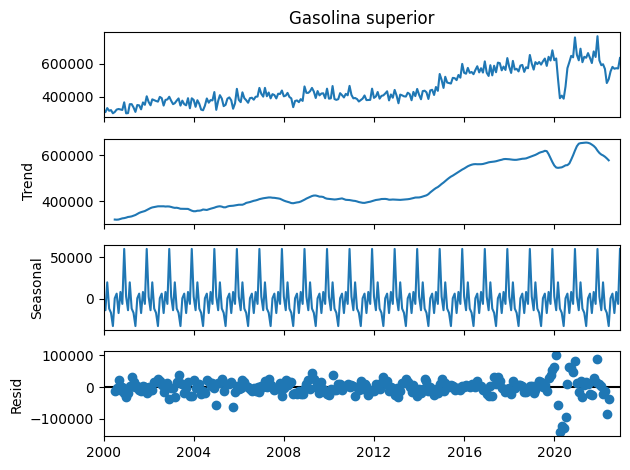

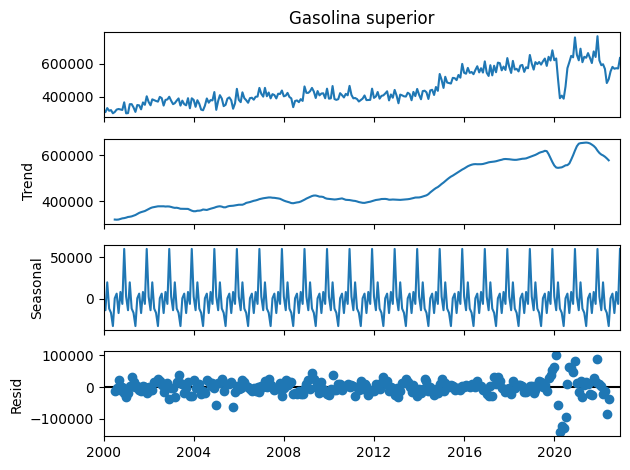

In [ ]:
descomposicion = seasonal_decompose(train_data["Gasolina superior"])
descomposicion.plot()

In [ ]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_data["Gasolina superior"], autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -1.268840
p-value                        0.643305
# de retardos usados          12.000000
# de observaciones usadas    263.000000
Critical Value (1%)           -3.455461
Critical Value (5%)           -2.872593
Critical Value (10%)          -2.572660
dtype: float64


In [ ]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
ts_air_pas_diff = train_data["Gasolina superior"].diff()
ts_air_pas_diff.dropna(inplace=True)
dfTest = adfuller(ts_air_pas_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba       -5.787650e+00
p-value                      4.956215e-07
# de retardos usados         1.100000e+01
# de observaciones usadas    2.630000e+02
Critical Value (1%)         -3.455461e+00
Critical Value (5%)         -2.872593e+00
Critical Value (10%)        -2.572660e+00
dtype: float64


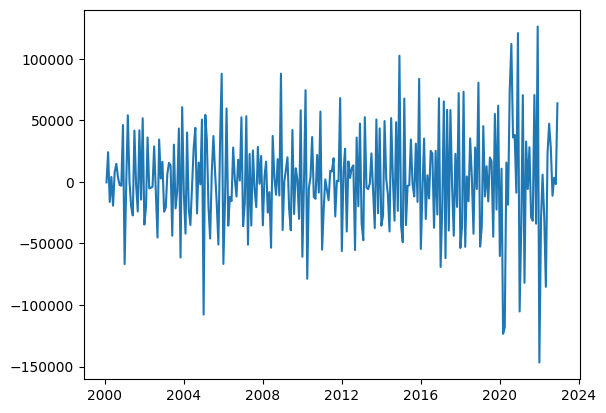

In [ ]:
plt.plot(ts_air_pas_diff)

In [ ]:
df = ts_air_pas_diff.to_frame()  # nombre por defecto será el nombre de la serie
print(df.columns)  # debería dar ['Gasolina superior'] o similar

Index(['Gasolina superior'], dtype='object')


In [ ]:
scaler = StandardScaler()
ts_air_pas_scaled = scaler.fit_transform(df[["Gasolina superior"]])
ts_air_pas_scaled[1:7]

array([[ 0.55337278],
       [-0.4208209 ],
       [ 0.06818075],
       [-0.49455076],
       [ 0.16313417],
       [ 0.32582129]])

In [ ]:
entrenamiento = round(0.6*len(ts_air_pas_scaled))
val_prueba = round(0.2*len(ts_air_pas_scaled))
test = ts_air_pas_scaled[(entrenamiento+val_prueba)-1:]
validation = ts_air_pas_scaled[(entrenamiento):entrenamiento+val_prueba+1]
train = ts_air_pas_scaled[0:entrenamiento]
train=np.insert(train,0,0)
train=np.reshape(train,(train.shape[0],1))
len(test)

56

In [ ]:
from operator import concat


def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train)
x_val,y_val = supervisada(validation)
x_test,y_test = supervisada(test)



In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))
len(x_val)

55

In [ ]:
modelo1 = Sequential()
lote = 1
unidades = 1
paso = 1
caracteristicas = 1  # univariada

modelo1.add(Input(batch_shape=(lote, paso, caracteristicas)))
modelo1.add(LSTM(units=unidades, stateful=True))
modelo1.add(Dense(1))

modelo1.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (1, 1)                 │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

In [ ]:
epocas = 95
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    verbose=1
)

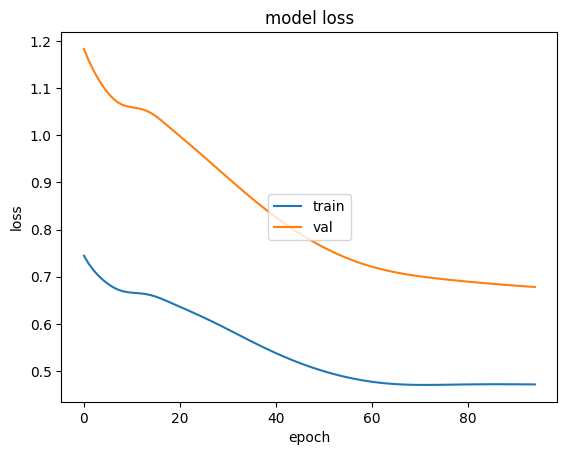

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

In [ ]:
modelo1.evaluate(x_train, y_train, batch_size=1)
modelo1.evaluate(x_val, y_val, batch_size=1)
modelo1.evaluate(x_test, y_test, batch_size=1)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4204
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6603  
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3295 


1.9374698400497437

In [120]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df[["Gasolina superior"]].values , n=entrenamiento)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = df[["Gasolina superior"]].values , n=entrenamiento+val_prueba)


In [121]:
df_val = pd.DataFrame(prediccion_val,
                      index=df[["Gasolina superior"]].iloc[entrenamiento:entrenamiento + len(prediccion_val)].index)

start = entrenamiento + len(prediccion_val)
end = start + len(prediccion_test)
df_test = pd.DataFrame(prediccion_test,
                       index=df[["Gasolina superior"]].iloc[start:end].index)


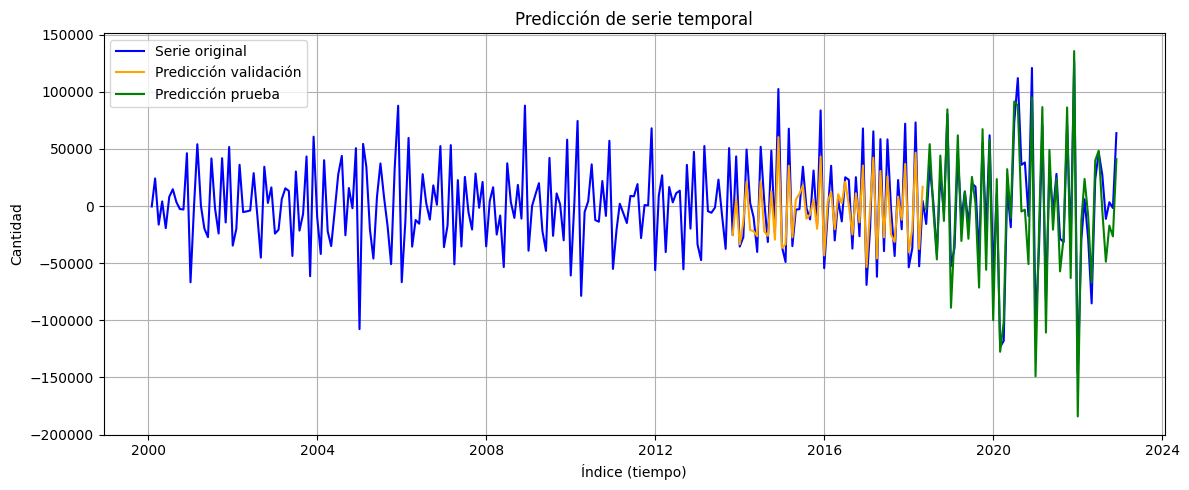

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))  

plt.plot(df[["Gasolina superior"]], label="Serie original", color="blue")

plt.plot(df_val, label="Predicción validación", color="orange")

plt.plot(df_test, label="Predicción prueba", color="green")

plt.title("Predicción de serie temporal")
plt.xlabel("Índice (tiempo)")
plt.ylabel("Cantidad")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()
